# Statistical analysis of the return times trough IDF

## Importation

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r
from scipy.optimize import minimize
import scipy
import numpy.random as rd

## Extraction des données

In [145]:
# Paramètres des données
Stations = ['Aigle', 'Pully', 'Payerne', 'Fretaz', 'Dole', 'Nyon']
stat_index = 1
Format = ['Minutes','Heures']
form_index = 0

# Importation et fusion des années 80-95 et 95-24
file_path1 = '../Data/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'8095.txt'
file_path2 = '../Data/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'9524.txt'

df = pd.read_csv(file_path1, sep=";", low_memory=False)
df_temp = pd.read_csv(file_path2, sep=";", low_memory=False)

Overlap_num = df['time'].max()
df_temp = df_temp[df_temp['time'] > Overlap_num]
df = pd.concat([df, df_temp], ignore_index=True)

# Epuration des données et temps/value en format adapté
del df_temp
del df['stn']
df = df.replace('-',0.0)
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H%M')
df = df[~df['time'].dt.year.isin([1980, 2025])]
df = df.reset_index(drop=True)

value_column = df.columns[1]
df[value_column] = pd.to_numeric(df[value_column], errors='coerce')

# Gestion des moyennes et maximas par an
N = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
num_years = len(df['time'].dt.year.unique())
maximas = np.zeros(shape=[len(N),num_years])


for i,n in enumerate(N):
    print(f'Aggregation: n = {n}')
    df_temp = df.copy()
    rows_to_keep = len(df_temp) - (len(df_temp) % n)
    df_temp = df_temp.iloc[:rows_to_keep]
    df_temp['group'] = np.floor(df_temp.index / n)
    df_temp['averaged'] = df_temp.groupby('group')[value_column].transform('mean')
    df_temp['year'] = df_temp['time'].dt.year
    pdmaximas = df_temp.groupby('year')['averaged'].max()
    del df_temp
    maximas[i] = np.array(pdmaximas)
    maximas[i] = np.sort(maximas[i])[::-1]

Aggregation: n = 1
Aggregation: n = 2
Aggregation: n = 3
Aggregation: n = 4
Aggregation: n = 5
Aggregation: n = 6
Aggregation: n = 7
Aggregation: n = 8
Aggregation: n = 9
Aggregation: n = 10
Aggregation: n = 11
Aggregation: n = 12


## Gumbel function and useful fct

In [146]:
def gumbel(gumbel_index):
    return np.exp(-np.exp(-gumbel_index))

def gumbel_inverse(probability):
    return -np.log(-np.log(probability))

def dense_gumbel(maxima, gumbel_param):
    return (1/gumbel_param[1])*np.exp(-((maxima-gumbel_param[0])/gumbel_param[1] + np.exp(-(maxima-gumbel_param[0])/gumbel_param[1])))

def gumbel_log_likelihood(maxima, gumbel_param):
    return -np.sum(np.log(dense_gumbel(maxima, gumbel_param)))

def gumbel_index_fct(maxima, gumbel_param):
    return (maxima-gumbel_param[0])/gumbel_param[1]

def maxima_from_gumbel_index(gumbel_index, gumbel_param):
    return gumbel_index * gumbel_param[1] + gumbel_param[0]

## Fit Gumbel avec log-likelihood

In [147]:
gumbel_param = np.zeros(shape=[len(N), 2])

for i, n in enumerate(N):
    maxima = maximas[i]
    # Fit the Gumbel distribution directly to the data
    loc, scale = gumbel_r.fit(maxima)
    gumbel_param[i, 0] = loc  # Store location parameter
    gumbel_param[i, 1] = scale  # Store scale parameter
    print(f"Fitted parameters for N={n}: a = {loc}, b = {scale}")

Fitted parameters for N=1: a = 9.462320976430135, b = 2.766905281572941
Fitted parameters for N=2: a = 6.081766336006628, b = 2.0526601526596036
Fitted parameters for N=3: a = 4.695933370740531, b = 1.6310745695237099
Fitted parameters for N=4: a = 3.8799497077633545, b = 1.3776404767499586
Fitted parameters for N=5: a = 3.182261709794073, b = 1.1871651084211472
Fitted parameters for N=6: a = 2.8067886938058586, b = 0.9693148672879135
Fitted parameters for N=7: a = 2.520364778250377, b = 0.9502046563382239
Fitted parameters for N=8: a = 2.2710068149310336, b = 0.7780421237732913
Fitted parameters for N=9: a = 2.11030082392114, b = 0.7329335194024688
Fitted parameters for N=10: a = 1.9651919342551047, b = 0.6701189939912979
Fitted parameters for N=11: a = 1.8180201340609323, b = 0.5449232726749511
Fitted parameters for N=12: a = 1.6738547138398414, b = 0.5189753653968979


## Hasen relation for estimating

In [148]:
estimated_quantiles = np.zeros(shape=[len(N),num_years])

for i, n in enumerate(N):
    maxima = maximas[i]
    ranks = np.arange(1, len(maxima) + 1)
    estimated_prob = 1 - ranks / len(maxima)
    estimated_quantiles[i] = gumbel_inverse(estimated_prob)

/var/folders/zf/2nzmqk7n5wl130dz3xf3krk00000gn/T/ipykernel_908/407864410.py:5: RuntimeWarning: divide by zero encountered in log
  return -np.log(-np.log(probability))


## Graphical check

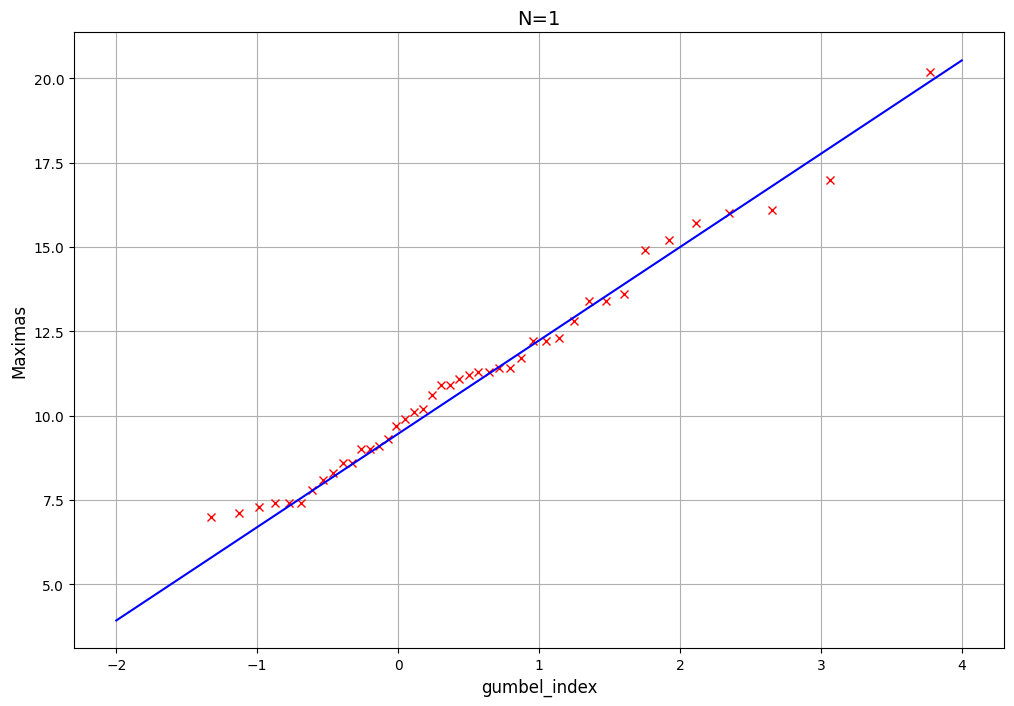

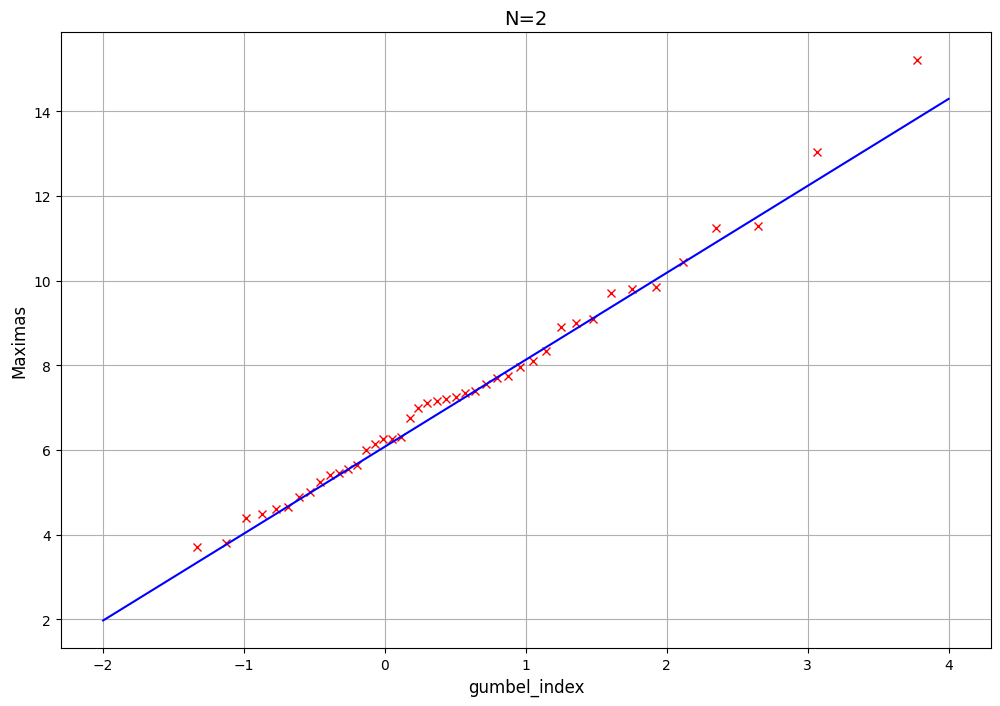

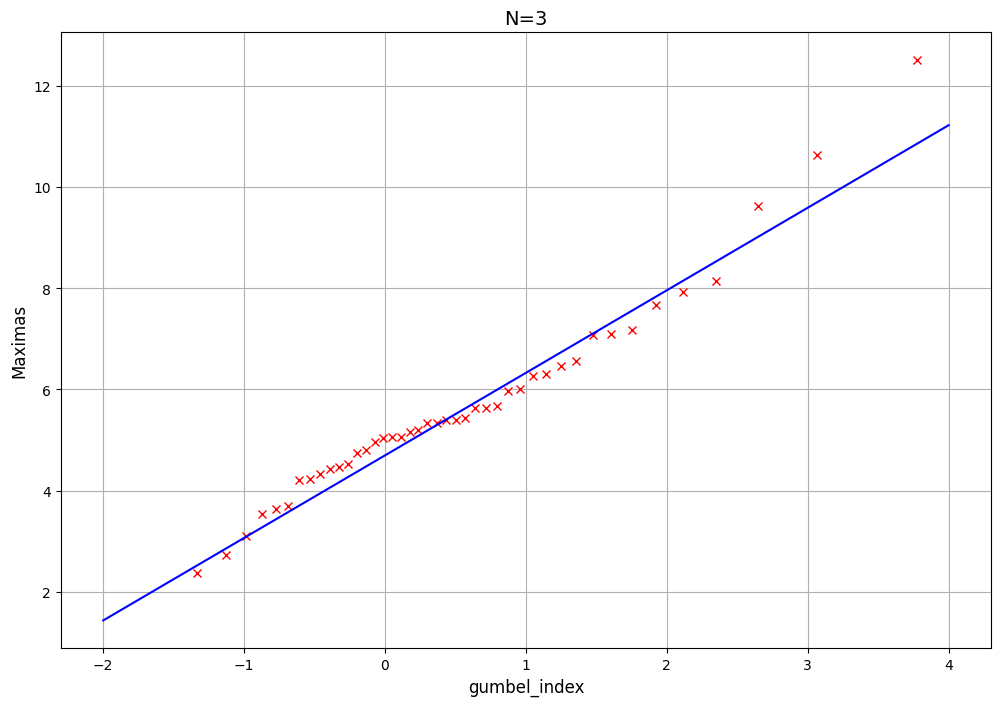

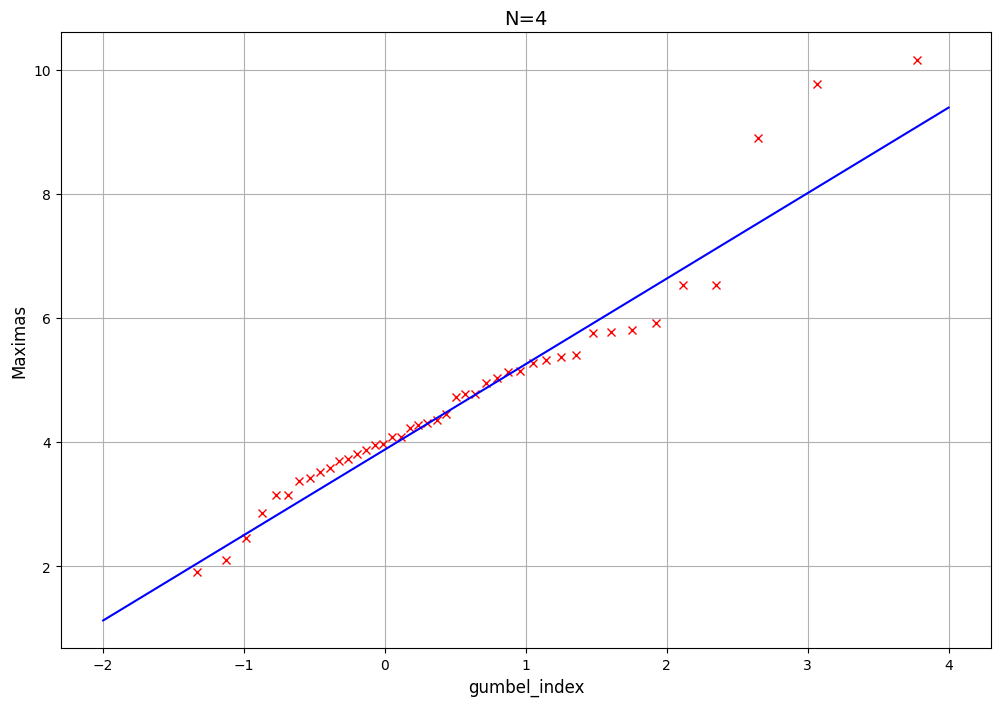

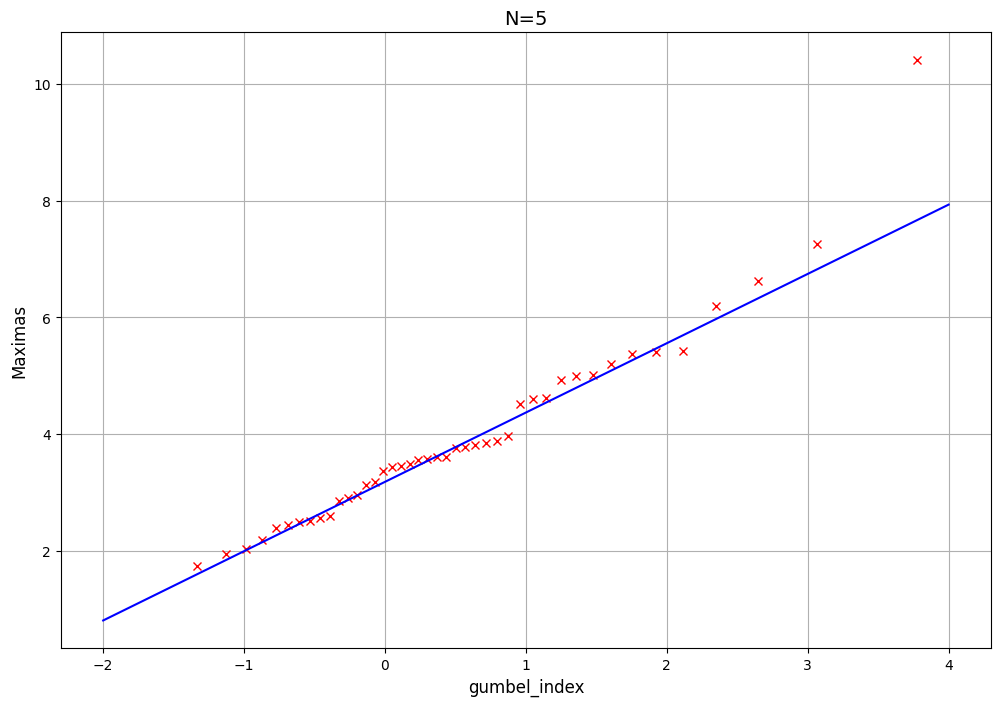

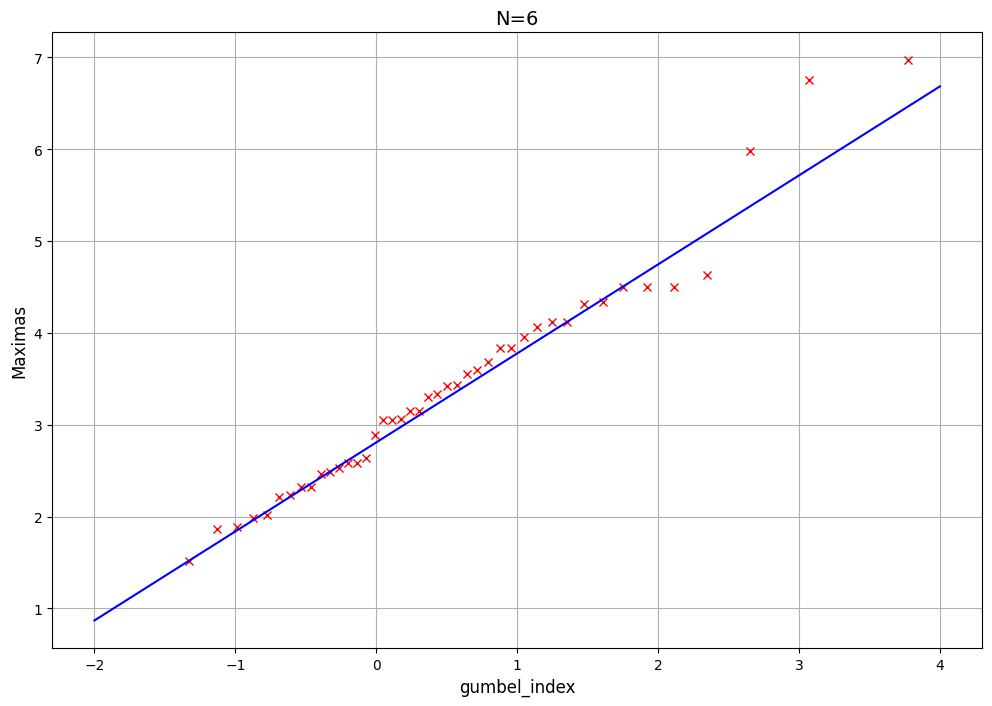

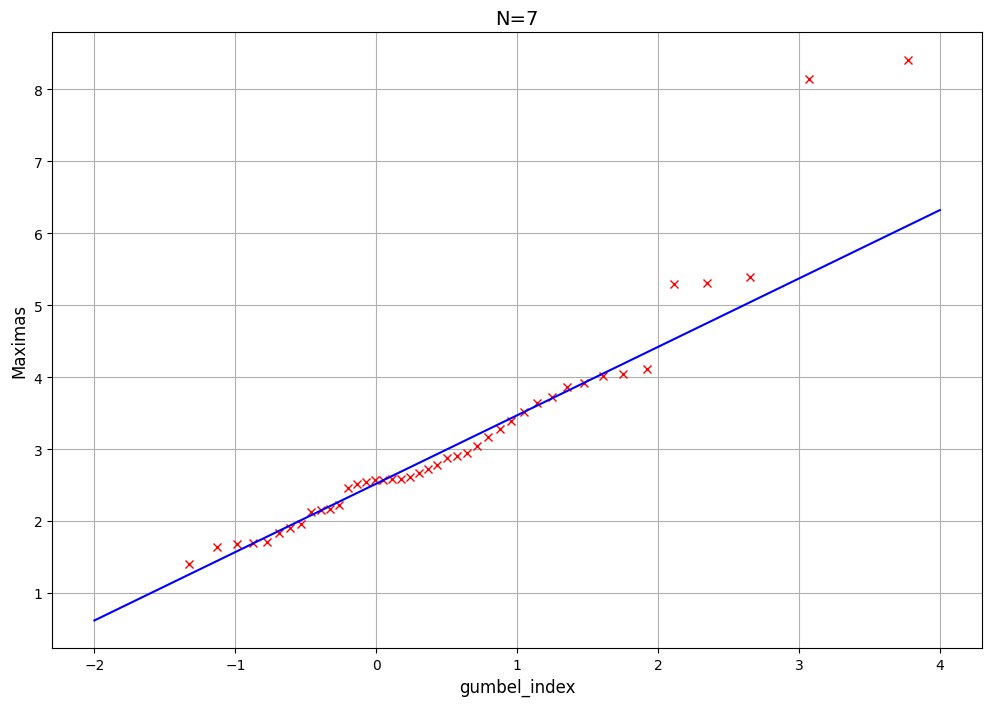

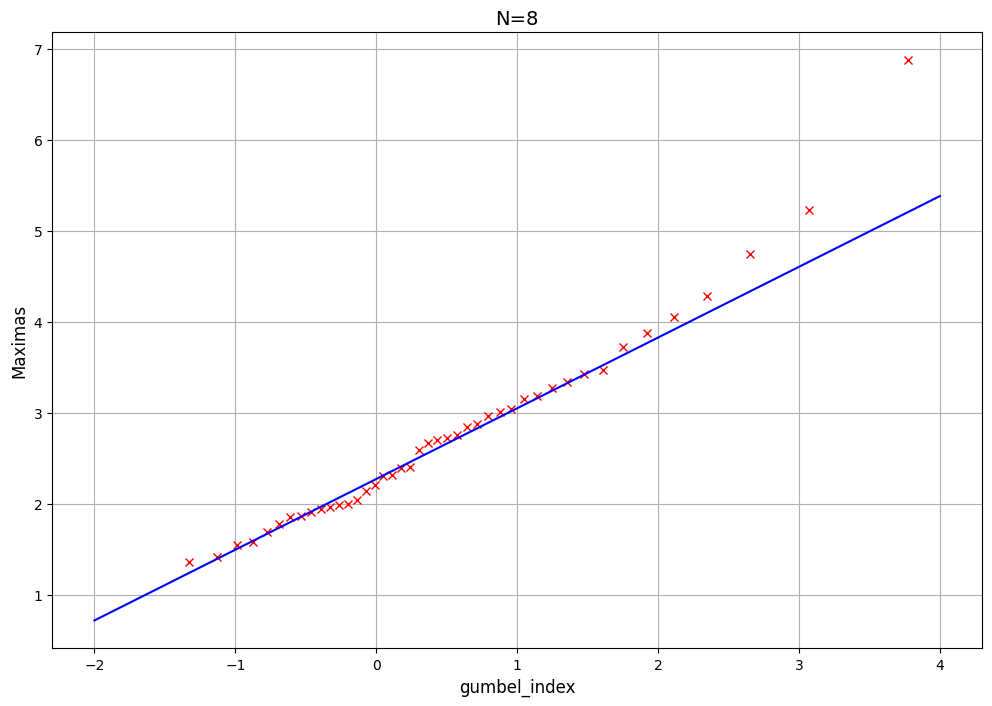

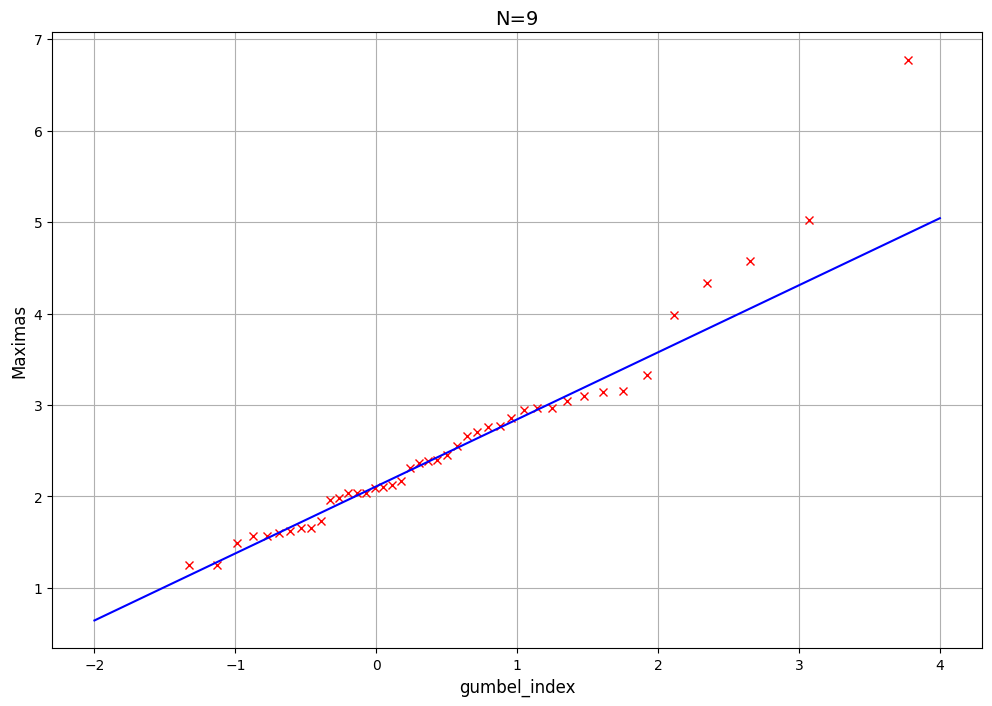

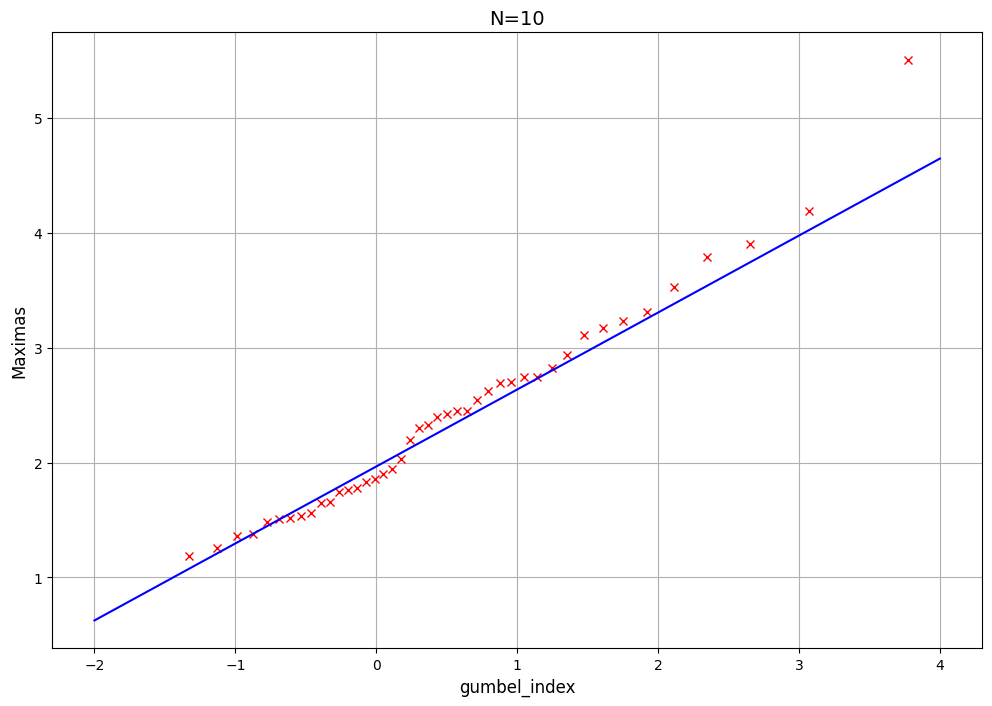

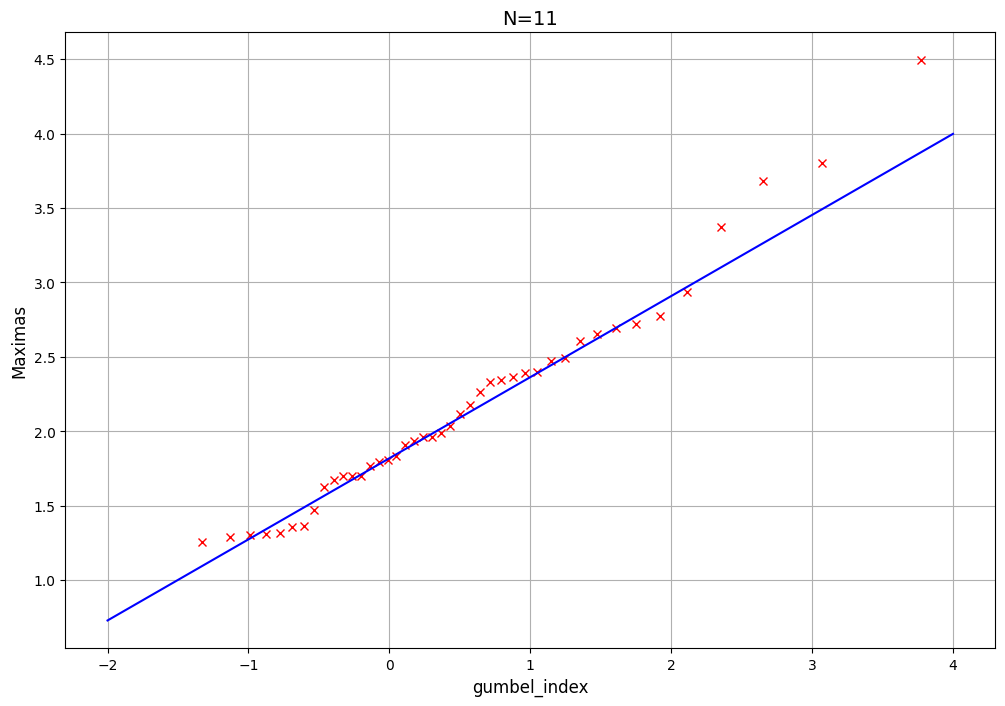

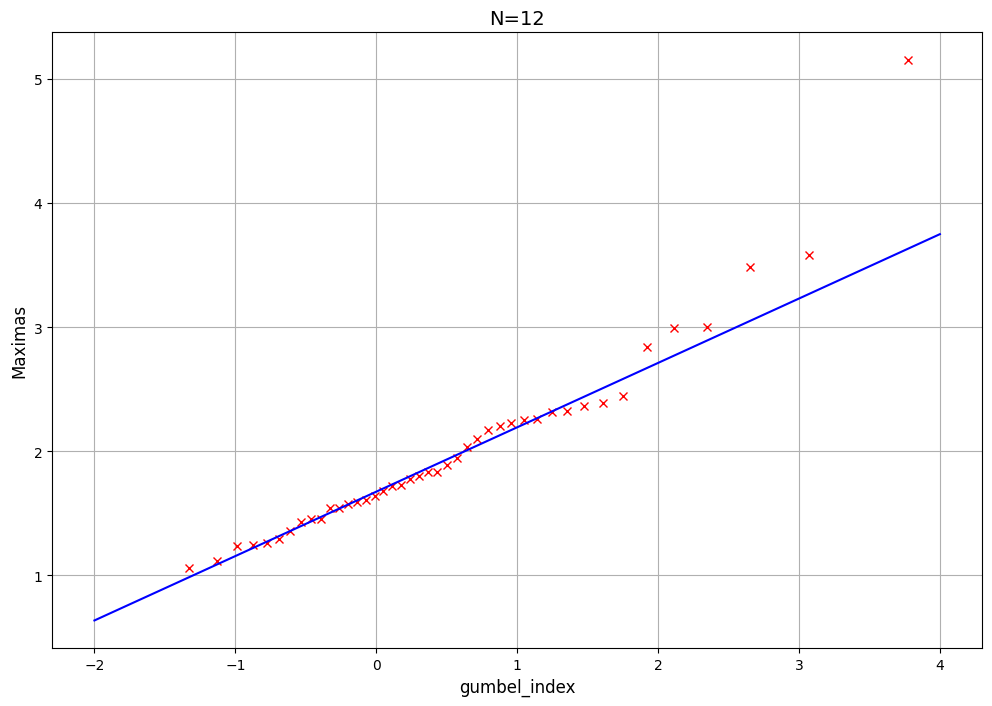

In [149]:
for i, n in enumerate(N):
    plt.figure(figsize=(12, 8))  # Create a new figure for each graph
    plt.plot(estimated_quantiles[i], np.sort(maximas[i])[::-1], 'rx')
    plt.plot(np.arange(-2,5,1),maxima_from_gumbel_index(np.arange(-2,5,1), gumbel_param[i]),'b-')
    plt.grid(True)
    plt.title(f'N={n}', fontsize=14)
    plt.xlabel('gumbel_index', fontsize=12)
    plt.ylabel('Maximas', fontsize=12)
    plt.show()

## Plot return time and intensity

/var/folders/zf/2nzmqk7n5wl130dz3xf3krk00000gn/T/ipykernel_908/175670566.py:4: RuntimeWarning: divide by zero encountered in divide
  Ts[i] = 1/(1-gumbel(gumbel_index_fct(maximas_plot,gumbel_param[i])))
/var/folders/zf/2nzmqk7n5wl130dz3xf3krk00000gn/T/ipykernel_908/175670566.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-1,80)


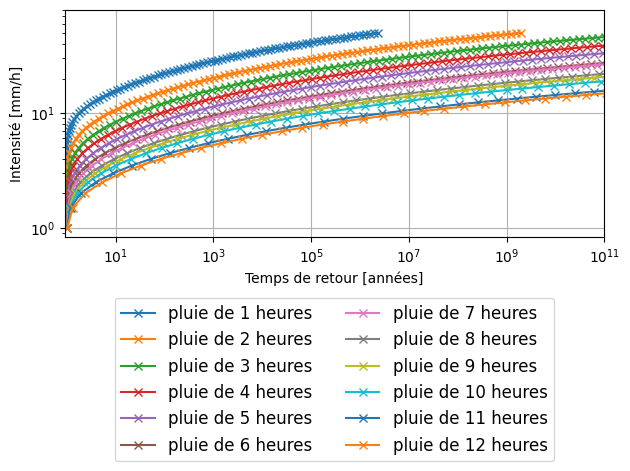

In [150]:
maximas_plot = np.linspace(1,50,100)
Ts = np.zeros(shape=[len(N), len(maximas_plot)])
for i,_ in enumerate(N):
    Ts[i] = 1/(1-gumbel(gumbel_index_fct(maximas_plot,gumbel_param[i])))

plt.figure()
plt.subplot()
for i,_ in enumerate(N):
    plt.plot(Ts[i],maximas_plot,'x-',label=f'pluie de {i+1} heures')
    plt.grid('on')
    plt.xscale('log')
    plt.xlim(0.9,1.e11)
    plt.yscale('log')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.23), ncol=2, fontsize=12)
    plt.tight_layout()
    plt.ylim(-1,80)
    plt.xlabel('Temps de retour [années]')
    plt.ylabel('Intensité [mm/h]')

## Talbot and montana functions and relationship between parameters

In [205]:
def montana(N, a, b):
    return a*(N**(-b))

def talbot(N, c, e):
    return c/(e+N)

def e_from_bd(dpivot, b):
    return dpivot*((1/b) - 1)

def c_from_abd(dpivot, a, b):
    return (a/b) * (dpivot**(1-b))

def talbot_residual(dpivot, N, a, b, Frequenciesinf):
    e = e_from_bd(dpivot, b)
    c = c_from_abd(dpivot, a, b)
    talbot_prediction = talbot(N, c, e)
    return talbot_prediction - Frequenciesinf

def idf_smooth(dpivot, N, a, b, k):
    e = e_from_bd(dpivot, b)
    c = c_from_abd(dpivot, a, b)
    z = -k * (N - dpivot)
    z = np.clip(z, -500, 500)
    sigmoid = 1/(1+np.exp(z))
    return (1-sigmoid)*talbot(N,c,e) + sigmoid*montana(N,a,b)

def smooth_residual(params, N, k, Frequencies):
    dpivot, a, b = params
    idf_pred = idf_smooth(dpivot, N, a, b, k)
    return idf_pred - Frequencies
    


## Fit of the talbot and montana parameters

In [208]:
T = np.array([2,5,10,25,50,100])
Frequencies = np.zeros(shape=[len(T), len(N)])

for j,_ in enumerate(N):
    Frequencies[:,j] = maxima_from_gumbel_index(gumbel_inverse(1-1/T),gumbel_param[j])

dpivot = np.array([2.5,3,4,5,4.7,5.5])

a,b,c,e = np.zeros(len(T)), np.zeros(len(T)), np.zeros(len(T)), np.zeros(len(T))

k = 1000

for i,t in enumerate(T):
    print('T:', t)
    Nsup = N[N>dpivot[i]]
    Frequenciessup = Frequencies[i,N>dpivot[i]]
    bminus, lna, _, _, _ = scipy.stats.linregress(np.log(Nsup), np.log(Frequenciessup))
    a[i] = np.exp(lna)
    b[i] = -bminus
    while True == True:
        result = scipy.optimize.least_squares(smooth_residual, [dpivot[i],a[i],b[i]], args=(N, k, Frequencies[i]))
        dpivot[i] = result.x[0]
        print('pivot: ', dpivot[i])

        #if len(Nsup) == len(N[N>dpivot[i]]):
        e[i] = e_from_bd(dpivot[i], b[i])
        c[i] = c_from_abd(dpivot[i], a[i], b[i])
        print('pivot final = ', dpivot[i])
        break

print('\n e =',e,'\n c =',c)
print('a =',a,'\n b =',b)

T: 2
pivot:  2.538796845967812
pivot final =  2.538796845967812
T: 5
pivot:  3.5780503841583675
pivot final =  3.5780503841583675
T: 10
pivot:  4.277337311853482
pivot final =  4.277337311853482
T: 25
pivot:  5.185441209851248
pivot final =  5.185441209851248
T: 50
pivot:  6.002378645444667
pivot final =  6.002378645444667
T: 100
pivot:  12.076118172281102
pivot final =  12.076118172281102

 e = [0.85895606 0.95755624 0.98619713 0.91263946 1.13043488 1.78640595] 
 c = [20.58332323 29.54471971 35.38210035 42.32128739 48.44042954 57.15299398]
a = [12.15237643 17.80759341 21.89880505 28.13043885 30.68449014 36.1160743 ] 
 b = [0.74719879 0.78888023 0.81263595 0.85033988 0.84151627 0.87113415]


## Plot of the Talbot-Montana curve

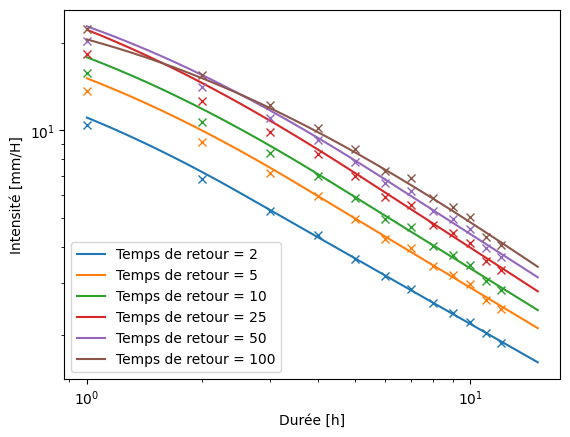

In [213]:
N_plot = np.linspace(1,15,1000)

plt.figure()
for i,t in enumerate(T):

    N_plot_sup = N_plot[N_plot>=dpivot[i]]
    N_plot_inf = N_plot[N_plot<=dpivot[i]]

    ligne1, = plt.plot(N, Frequencies[i],'x')
    color = ligne1.get_color()
    plt.plot(N_plot_sup, montana(N_plot_sup,a[i],b[i]),'-', color=color, label=f'Temps de retour = {t}')
    plt.plot(N_plot_inf, talbot(N_plot_inf,c[i],e[i]),'-', color=color)
    #plt.plot(N_plot, idf_smooth(dpivot[i], N_plot, a[i], b[i], k), color=color)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Durée [h]')
    plt.ylabel('Intensité [mm/H]')
    plt.legend()
plt.show()